# EDA of ECG Beats

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
import pywt

%matplotlib inline

In [3]:
def load_mitbih(fpath, split_name):

    # Load raw data
    df = pd.read_csv(fpath, header=None)

    # Count
    n_features = df.shape[1] - 1

    # Stable arbitrary ID: split + row index
    df["instance_id"] = [f"{split_name}_{i}" for i in range(len(df))]

    # Fix column names
    df.columns = (
        [f"x{i}" for i in range(n_features)]
        + ["label"]
        + ["instance_id"]
    )

    return df

In [ ]:
mitbih_train = load_mitbih("data/raw/mitbih_train.csv", "train")
mitbih_test = load_mitbih("data/raw/mitbih_test.csv", "test")
mit_raw = pd.concat([mitbih_train, mitbih_test], axis = 0)
mit_raw.to_csv("data/intermediate/mit_raw.csv")
mit_raw.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x179,x180,x181,x182,x183,x184,x185,x186,label,instance_id
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train_0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train_1
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train_2
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train_3
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train_4


In [4]:
counts = mit_raw["label"].value_counts().sort_index()
percent = counts / counts.sum() * 100

class_counts = pd.DataFrame({
    "count": counts,
    "percent": percent.round(2)
})

class_counts

,count,percent
label,,
0.0,90589,82.77
1.0,2779,2.54
2.0,7236,6.61
3.0,803,0.73
4.0,8039,7.35


In [5]:
def make_features(x, fs = 360):

    # Helper functions
    def spectral_entropy(psd):
        psd_norm = psd / np.sum(psd)
        return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))

    def band_power(fmin, fmax):
        mask = (freqs >= fmin) & (freqs < fmax)
        return np.sum(psd[mask])
    
    # Cast array into numpy format
    x = np.asarray(x)

    # Compute differences
    dx = np.diff(x)
    
    # Define dictionary to store features
    feats = dict()

    # Time-domain features
    feats["mean"] = np.mean(x)
    feats["median"] = np.median(x)
    feats["std"] = np.std(x)
    feats["var"] = np.var(x)
    #feats["min"] = np.min(x)
    #feats["max"] = np.max(x)
    feats["iqr"] = stats.iqr(x)
    feats["rms"] = np.sqrt(np.mean(x ** 2))
    #feats["mean_abs"] = np.mean(np.abs(x))
    feats["skew"] = stats.skew(x)
    feats["kurtosis"] = stats.kurtosis(x)
    #feats["zcr"] = np.mean(np.diff(np.sign(x)) != 0)

    # Complexity
    feats["signal_length"] = np.sum(np.abs(dx))
    feats["turning_points"] = np.sum((dx[:-1] * dx[1:]) < 0)

    # Hjorth parameters
    var_x = np.var(x)
    var_dx = np.var(dx)
    var_ddx = np.var(np.diff(dx))

    feats["hjorth_activity"] = var_x
    feats["hjorth_mobility"] = np.sqrt(var_dx / (var_x + 1e-12))
    feats["hjorth_complexity"] = (
        np.sqrt(var_ddx / (var_dx + 1e-12)) / (feats["hjorth_mobility"] + 1e-12)
    )

    # Slope features
    feats["max_abs_slope"] = np.max(np.abs(dx))
    feats["mean_abs_slope"] = np.mean(np.abs(dx))
    feats["std_slope"] = np.std(dx)
    feats["pos_slope_ratio"] = np.mean(dx > 0)
    feats["neg_slope_ratio"] = np.mean(dx < 0)

    # Peak features
    peaks, props = signal.find_peaks(x, distance=fs * 0.05, prominence=0.05)

    feats["num_peaks"] = len(peaks)
    
    if len(peaks) > 0:
        feats["peak_height_mean"] = np.mean(x[peaks])
        feats["peak_height_std"] = np.std(x[peaks])
        feats["peak_prom_mean"] = np.mean(props["prominences"])
        feats["peak_prom_std"] = np.std(props["prominences"])
    else:
        feats["peak_height_mean"] = 0
        feats["peak_height_std"] = 0
        feats["peak_prom_mean"] = 0
        feats["peak_prom_std"] = 0

    # Frequency-domain features
    freqs, psd = signal.welch(x, fs=fs, nperseg=min(128, len(x)))

    feats["spec_entropy"] = spectral_entropy(psd)
    feats["spec_centroid"] = np.sum(freqs * psd) / np.sum(psd)
    feats["spec_spread"] = np.sqrt(
        np.sum(((freqs - feats["spec_centroid"])**2) * psd) / np.sum(psd)
    )
    feats["total_power"] = np.sum(psd)

    feats["bp_0_5"] = band_power(0, 5)
    feats["bp_5_15"] = band_power(5, 15)
    feats["bp_15_40"] = band_power(15, 40)

    feats["bp_ratio_lf_hf"] = feats["bp_5_15"] / (feats["bp_15_40"] + 1e-12)

    # Wavelet features
    coeffs = pywt.wavedec(x, "db4", level=4)

    for i, c in enumerate(coeffs):
        feats[f"wl{i}_mean"] = np.mean(c)
        feats[f"wl{i}_std"] = np.std(c)
        feats[f"wl{i}_energy"] = np.sum(c**2)
        feats[f"wl{i}_entropy"] = spectral_entropy(np.abs(c) + 1e-12)

    return feats

In [6]:
# Compute features from raw df
feature_cols = [c for c in mit_raw.columns if c.startswith("x")]
X = mit_raw[feature_cols].to_numpy(dtype = np.float32)

feat_rows = [make_features(x) for x in X]
feat_df = pd.DataFrame(feat_rows)

features_df = pd.concat([mit_raw[["instance_id", "label"]].reset_index(drop = True), feat_df], axis=1)

features_df.to_csv("data/intermediate/features_df.csv")

In [7]:
features_df.head()

,instance_id,label,mean,median,std,var,iqr,rms,skew,kurtosis,...,wl2_energy,wl2_entropy,wl3_mean,wl3_std,wl3_energy,wl3_entropy,wl4_mean,wl4_std,wl4_energy,wl4_entropy
0,train_0,0.0,0.098419,0.061275,0.176073,0.031002,0.127451,0.201713,3.546201,13.625458,...,3.092462,2.784985,-0.001263,0.092072,0.440899,3.446628,-0.001050,0.022465,0.049062,4.520406
1,train_1,0.0,0.090010,0.054131,0.159722,0.025511,0.089744,0.183338,3.835006,16.261442,...,2.912508,3.188208,0.006891,0.099999,0.522455,3.918475,-0.001608,0.019330,0.036496,5.496482
2,train_2,0.0,0.062104,0.005405,0.138769,0.019257,0.058108,0.152032,4.324592,22.166908,...,2.404316,2.685323,0.003689,0.114485,0.682261,3.184270,0.004120,0.035490,0.123822,4.486136
3,train_3,0.0,0.084084,0.002762,0.160821,0.025863,0.110497,0.181476,3.477491,13.691748,...,1.381033,2.981231,0.007277,0.096107,0.483050,3.671304,0.002444,0.013934,0.019413,5.028199
4,train_4,0.0,0.116567,0.056338,0.186151,0.034652,0.145540,0.219637,3.109725,10.238894,...,1.897863,3.000491,-0.014618,0.056436,0.176734,4.423923,-0.000971,0.013421,0.017564,5.524272


In [11]:
def plot_features(df, n_features=12, n_cols=4, random_state=42, kind="violin"):
    """
    Faceted grid of feature distribution plots, one facet per feature.
    Each facet shows value distribution by 'label'.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'label' and feature columns. Optional: 'instance_id'.
    n_features : int
        Number of feature columns to include (subsampled if more exist).
    n_cols : int
        Number of facet columns in the grid.
    random_state : int
        For reproducible feature subsampling.
    kind : str
        "box" or "violin"
    """
    if "label" not in df.columns:
        raise ValueError("df must contain a 'label' column.")

    # 1) numeric feature columns (exclude IDs/labels)
    feature_cols = [
        c for c in df.columns
        if c not in ["instance_id", "label"]
        and np.issubdtype(df[c].dtype, np.number)
    ]
    if not feature_cols:
        raise ValueError("No numeric feature columns found to plot.")

    # 2) pick features
    rng = np.random.default_rng(random_state)
    if len(feature_cols) > n_features:
        features_to_keep = list(rng.choice(feature_cols, size=n_features, replace=False))
    else:
        features_to_keep = feature_cols

    # 3) long-form for seaborn
    long_df = df[["label"] + features_to_keep].melt(
        id_vars="label", var_name="feature", value_name="value"
    )

    # 4) facet grid
    n_rows = math.ceil(len(features_to_keep) / n_cols)
    height = 3.0
    aspect = 1.1

    g = sns.FacetGrid(
        long_df,
        col="feature",
        col_wrap=n_cols,
        sharey=False,
        height=height,
        aspect=aspect
    )

    if kind == "violin":
        g.map_dataframe(sns.violinplot, x="label", y="value", inner="quartile", cut=0, hue = "label")
    else:
        # box by default
        g.map_dataframe(sns.boxplot, x="label", y="value", showfliers=False, hue = "label")

    # Make it readable
    g.set_titles("{col_name}")
    for ax in g.axes.flatten():
        ax.tick_params(axis="x", rotation=0)
        ax.set_xlabel("label")

    plt.tight_layout()
    plt.show()


/var/folders/fv/rpkkw_q539gfyp3mgkznp81m0000gs/T/ipykernel_17444/3124774118.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n = min(N, len(g)), random_state = 42))
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:

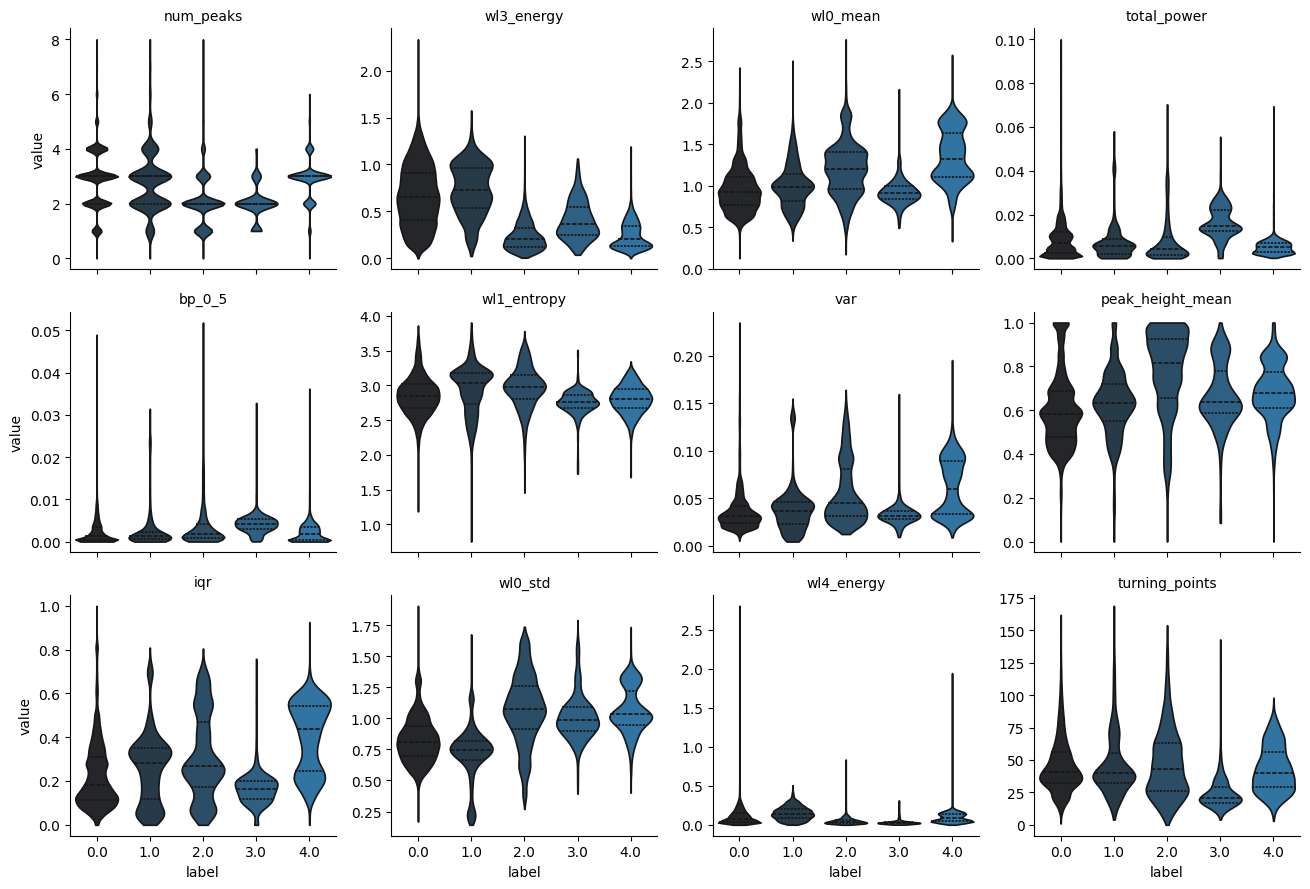

In [12]:
N = 50

plot_df = (
    features_df
    .groupby("label", group_keys = False)
    .apply(lambda g: g.sample(n = min(N, len(g)), random_state = 42))
)

plot_features(features_df)

/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting

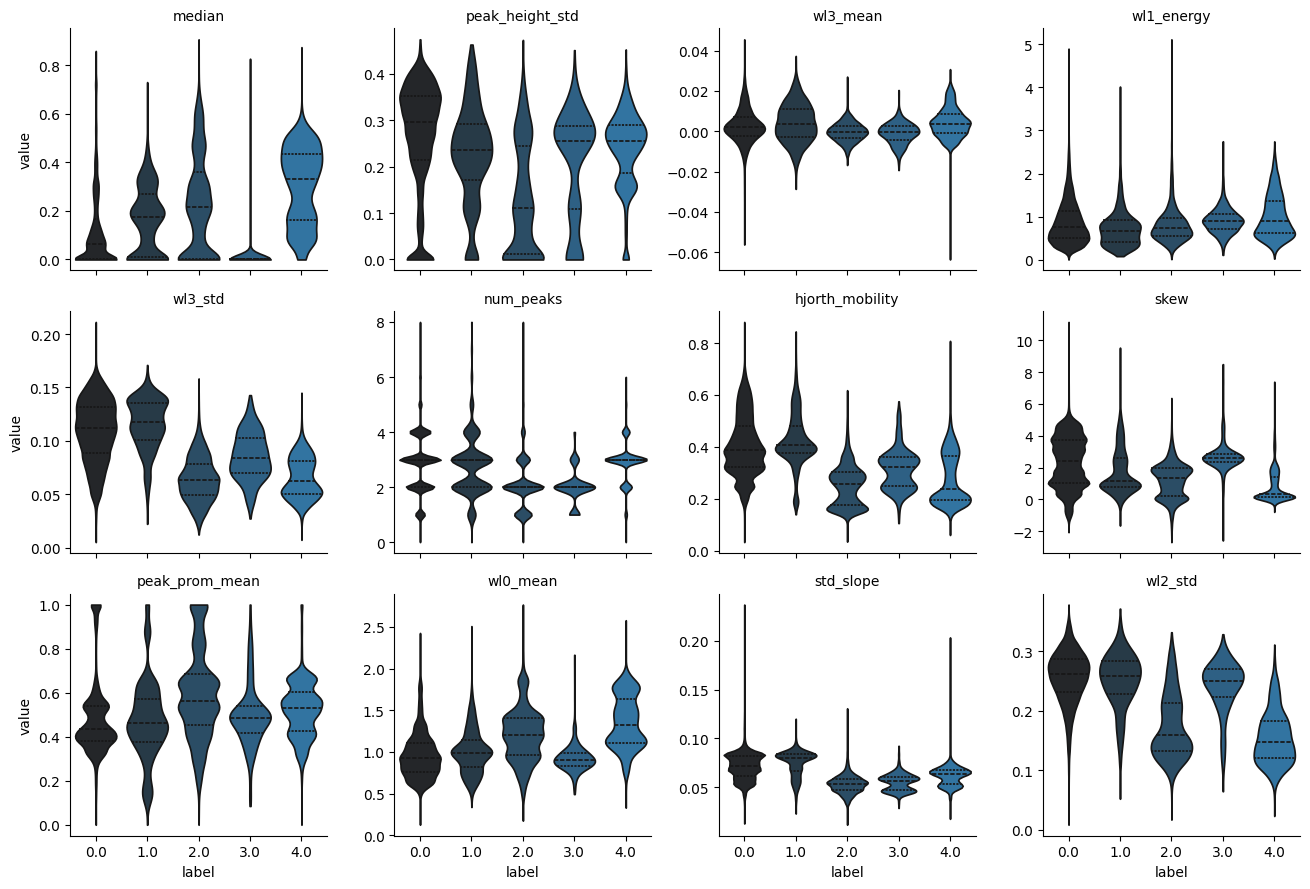

/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting

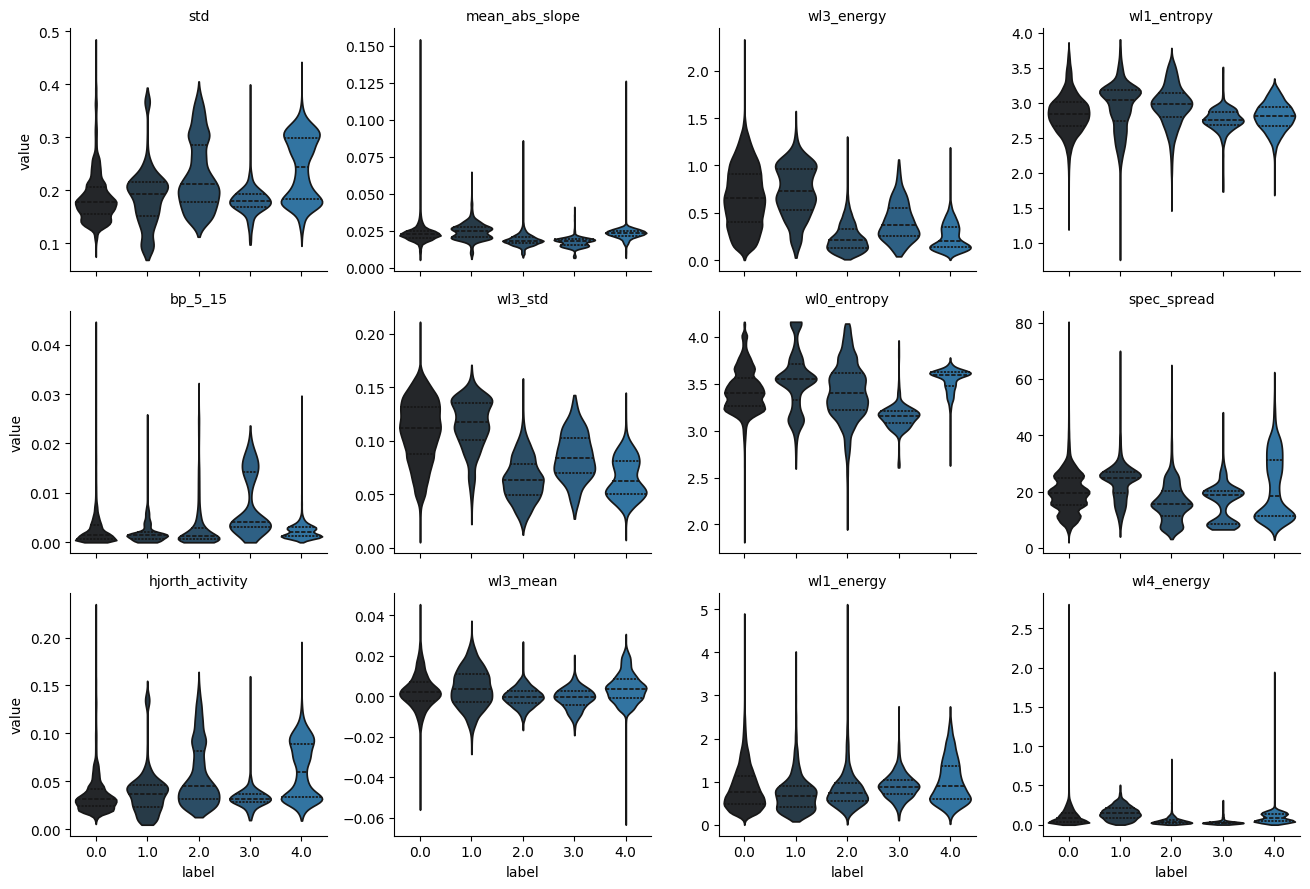

/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting

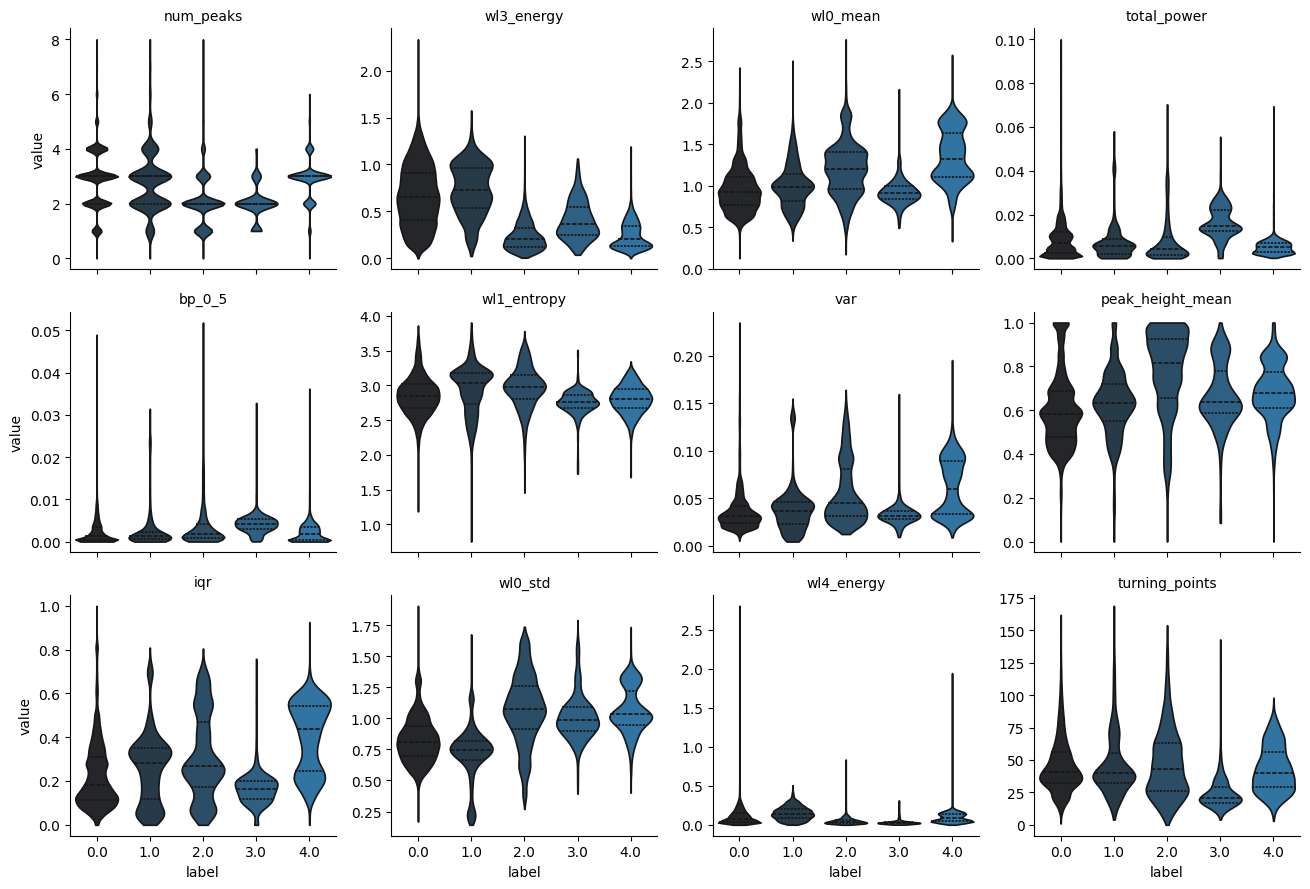

/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting

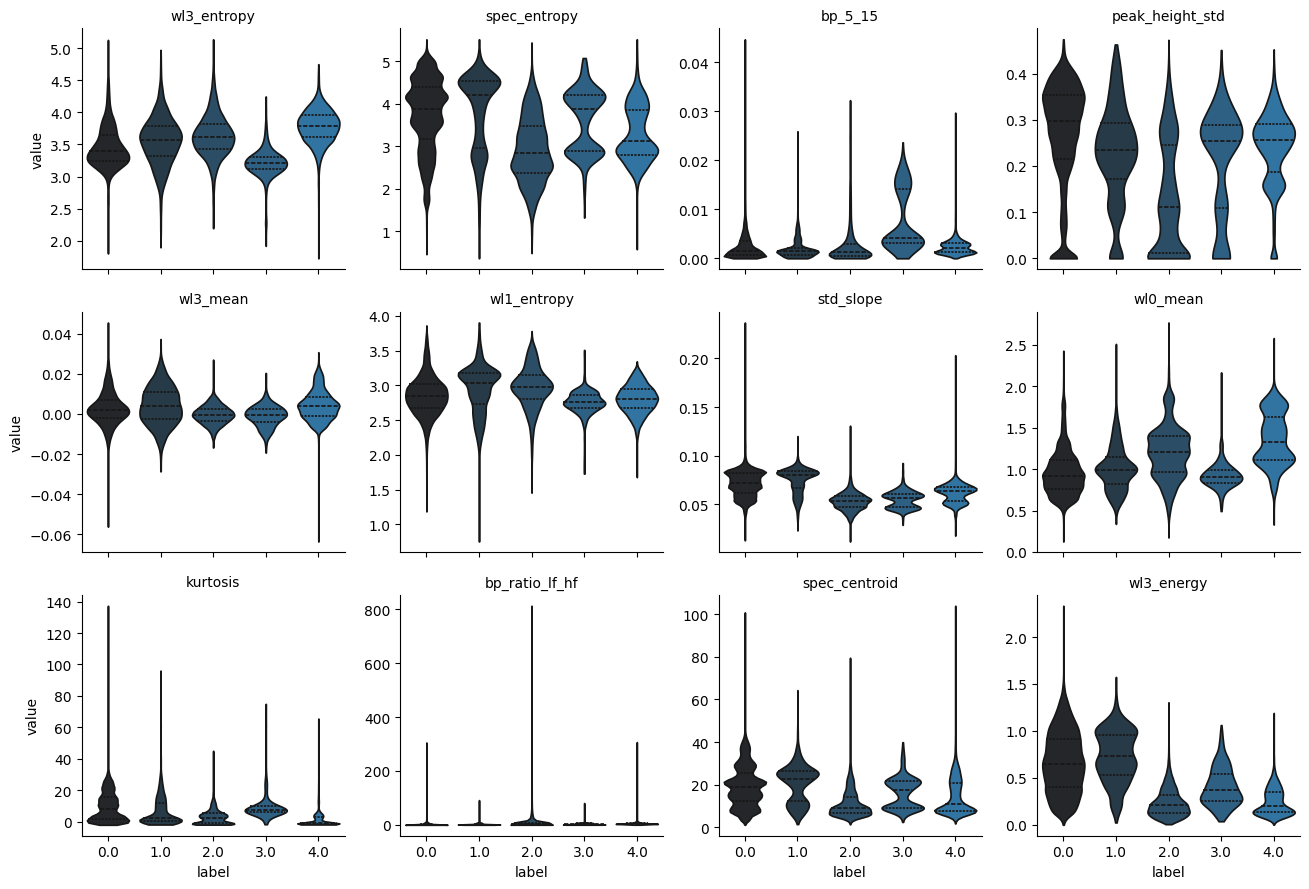

/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/m092364/Documents/projects/ecg_beats/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting

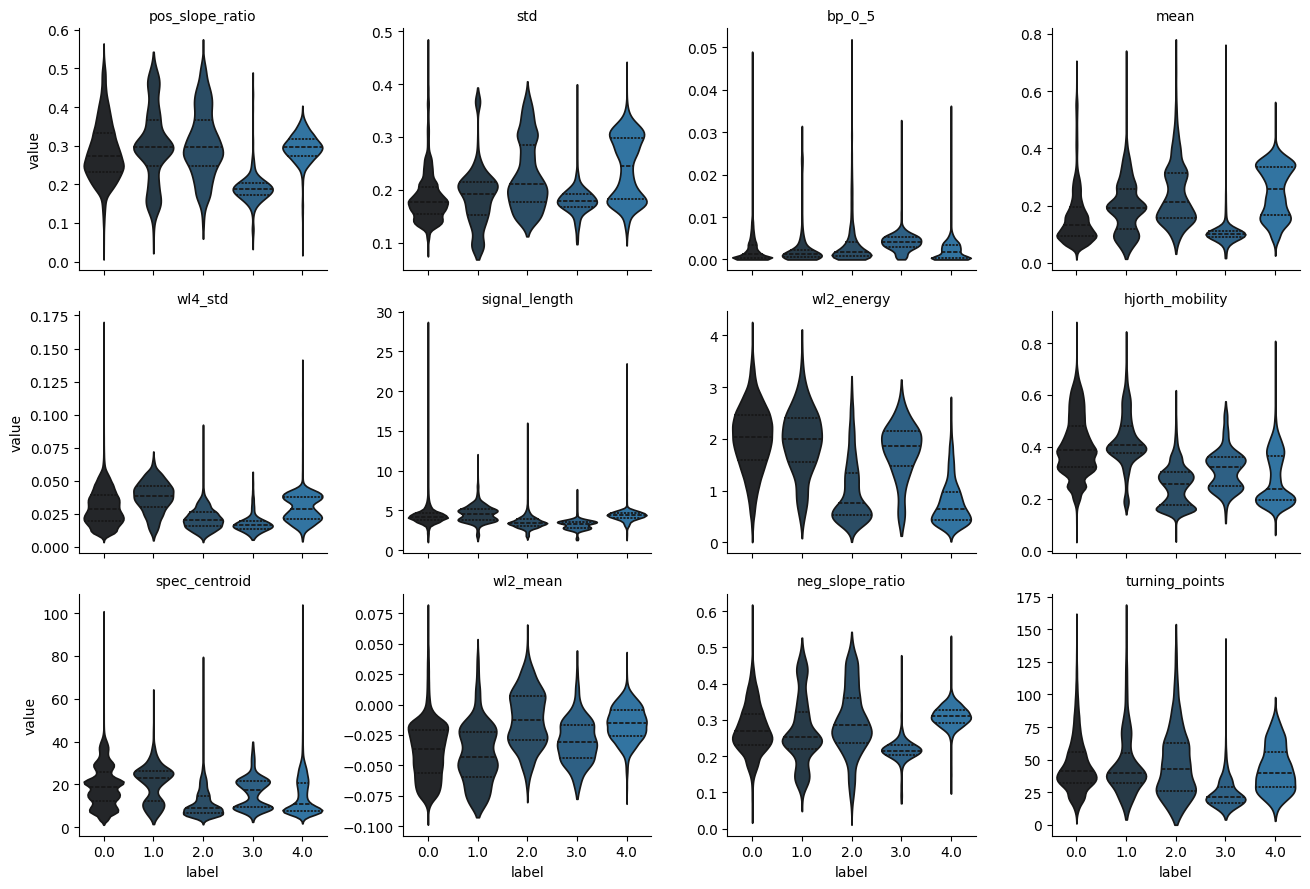

In [13]:
seeds = [1, 7, 42, 99, 123]

for seed in seeds:
    plot_features(features_df, random_state = seed)